In [1]:
from pathlib import Path
from typing import Iterable
import re

import pandas as pd
import plotnine as gg
import janitor


In [2]:
_ = gg.theme_set(
    gg.theme_classic()
    + gg.theme(axis_ticks=gg.element_blank(), strip_background=gg.element_blank())
)
%matplotlib inline
%config InlineBackend.figure_format='retina'

library_pal = {"pymc3": "#12698A", "stan": "#B2001D"}

In [3]:
project_root_dir = Path("..")
benchmarks_dir = project_root_dir / "benchmarks"
n_benchmarks = len(list(benchmarks_dir.iterdir()))
print(f"number of benchmarks: {n_benchmarks}")

model_size_csv = project_root_dir / "model-result-file-sizes.csv"
assert model_size_csv.is_file() and model_size_csv.exists()


number of benchmarks: 16


| colname   |   type (unit)   | description                                                                                                                                                                         |
|-----------|:---------------:|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| s         | float (seconds) | Running time in seconds                                                                                                                                                             |
| h:m:s     |    string (-)   | Running time in hour, minutes, seconds format                                                                                                                                       |
| max_rss   |    float (MB)   | Maximum "Resident Set Size”, this is the non-swapped physical memory a process has used.                                                                                            |
| max_vms   |    float (MB)   | Maximum “Virtual Memory Size”, this is the total amount of virtual memory used by the process                                                                                       |
| max_uss   |    float (MB)   | “Unique Set Size”, this is the memory which is unique to a process and which would be freed if the process was terminated right now.                                                |
| max_pss   |    float (MB)   | “Proportional Set Size”, is the amount of memory shared with other processes, accounted in a way that the amount is divided evenly between the processes that share it (Linux only) |
| io_in     |    float (MB)   | the number of MB read (cumulative).                                                                                                                                                 |
| io_out    |    float (MB)   | the number of MB written (cumulative).                                                                                                                                              |
| mean_load |    float (-)    | CPU usage over time, divided by the total running time (first row)                                                                                                                  |
| cpu_time  |     float(-)    | CPU time summed for user and system                                                                                                                                                 |

In [4]:
def read_benchmark(file: Path) -> pd.DataFrame:
    return pd.read_table(file, sep="\t").assign(name=file.name.replace(file.suffix, ""))


def stan_or_pymc3(names: Iterable[str]) -> list[str]:
    return [re.findall("stan|pymc3", n)[0] for n in names]


def _fix_simple_model_names(names: Iterable[str]) -> list[str]:
    new_names: list[str] = []
    for name in names:
        new_names.append(
            name.replace("simple-pymc3-", "simple_pymc3_").replace(
                "simple-stan-", "simple_stan_"
            )
        )
    return new_names


def parse_model_names(df: pd.DataFrame, col: str = "name") -> pd.DataFrame:
    return df.assign(
        library=lambda d: stan_or_pymc3(d.name),
        model=lambda d: [x.split("_")[0].strip() for x in d.name],
        data_size=lambda d: [x.split("_")[2].strip() for x in d.name],
    )


benchmarks = (
    pd.concat(read_benchmark(f) for f in benchmarks_dir.iterdir())
    .assign(name=lambda d: _fix_simple_model_names(d.name))
    .reset_index(drop=True)
    .pipe(parse_model_names)
    .assign(time_minutes=lambda d: d.s / 60.0)
)
benchmarks.head()


,s,h:m:s,max_rss,max_vms,max_uss,max_pss,io_in,io_out,mean_load,cpu_time,name,library,model,data_size,time_minutes
0,8.8233,0:00:08,671.82,3314.0,154.39,196.26,0.0,1.73,39.49,4.55,simple_stan_1000,stan,simple,1000,0.147055
1,6.6566,0:00:06,670.45,3312.46,169.3,200.78,0.0,0.77,38.87,3.59,simple_stan_1000,stan,simple,1000,0.110943
2,7.6303,0:00:07,671.72,3314.12,140.62,200.6,0.0,1.73,47.33,4.22,simple_stan_1000,stan,simple,1000,0.127172
3,8.2980,0:00:08,671.8,3314.13,169.21,244.59,0.0,1.74,36.02,4.22,simple_stan_1000,stan,simple,1000,0.138300
4,6.2739,0:00:06,675.38,3310.0,135.83,198.91,0.0,0.77,37.84,3.11,simple_stan_1000,stan,simple,1000,0.104565


In [5]:
benchmark_metrics = [
    "time_minutes",
    "max_rss",
    "max_vms",
    "max_pss",
    "cpu_time",
    "mean_load",
]
benchmark_ids = ["name", "model", "library", "data_size"]

benchmarks_long = (
    benchmarks[benchmark_ids + benchmark_metrics]
    .pivot_longer(benchmark_ids)
    .query("value != '-'")
    .astype({"value": "float"})
)

benchmarks_long["variable"] = pd.Categorical(
    benchmarks_long["variable"], categories=benchmark_metrics, ordered=True
)

benchmarks_long.head()


,name,model,library,data_size,variable,value
0,simple_stan_1000,simple,stan,1000,time_minutes,0.147055
1,simple_stan_1000,simple,stan,1000,time_minutes,0.110943
2,simple_stan_1000,simple,stan,1000,time_minutes,0.127172
3,simple_stan_1000,simple,stan,1000,time_minutes,0.138300
4,simple_stan_1000,simple,stan,1000,time_minutes,0.104565


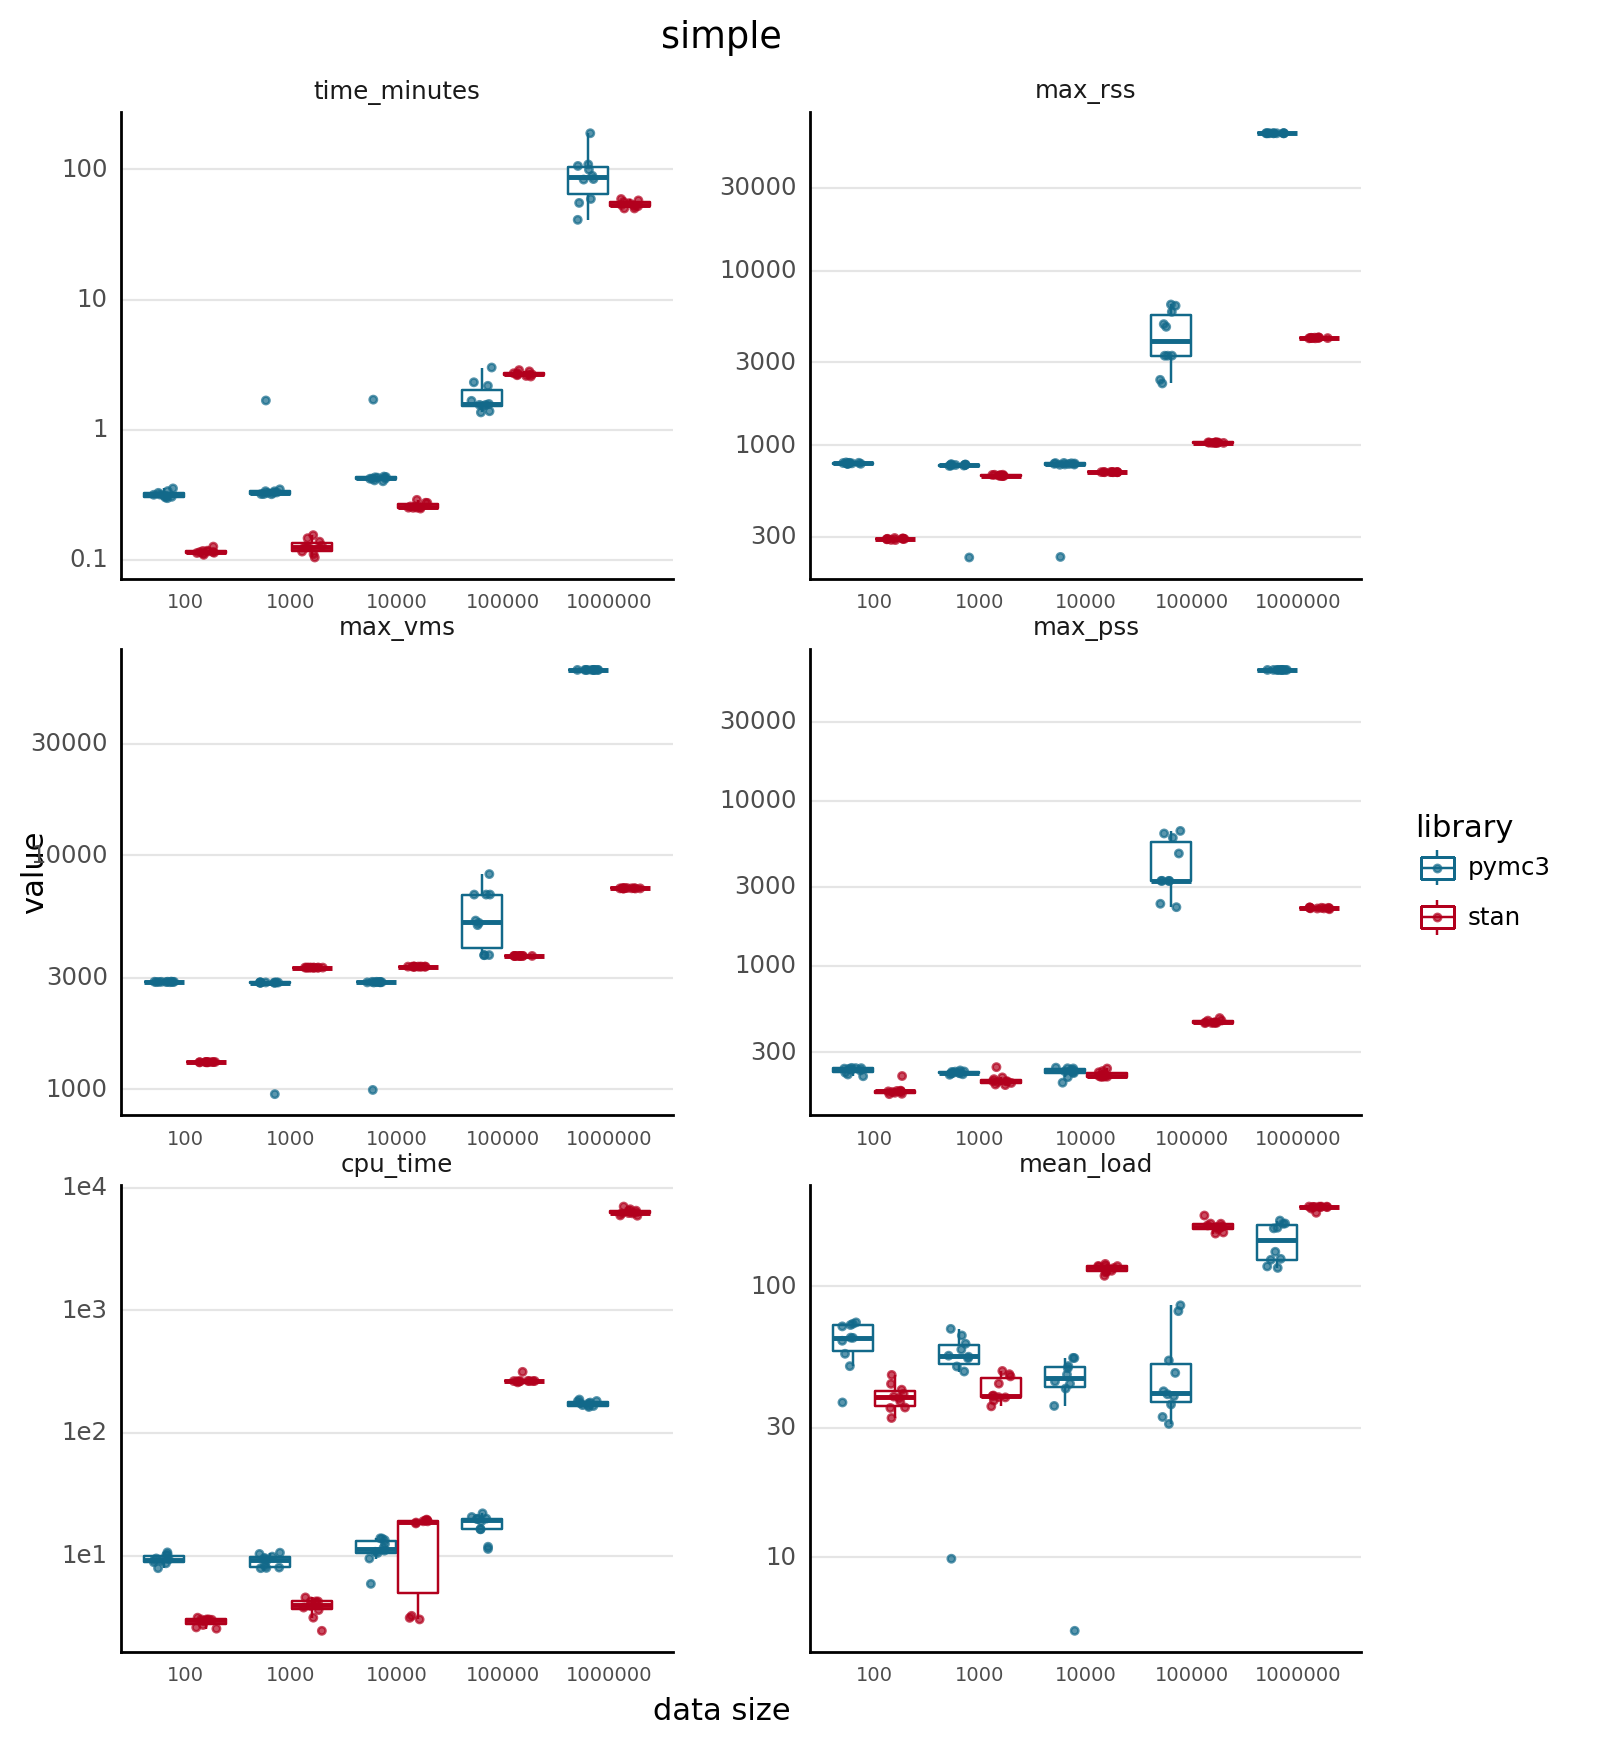

/Users/admin/Developer/Python/pymc3-stan-comparison/.snakemake/conda/442d6088f2f6ae04bd1fd806b4898007/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
/Users/admin/Developer/Python/pymc3-stan-comparison/.snakemake/conda/442d6088f2f6ae04bd1fd806b4898007/lib/python3.9/site-packages/plotnine/layer.py:324: PlotnineWarning: stat_boxplot : Removed 16 rows containing non-finite values.


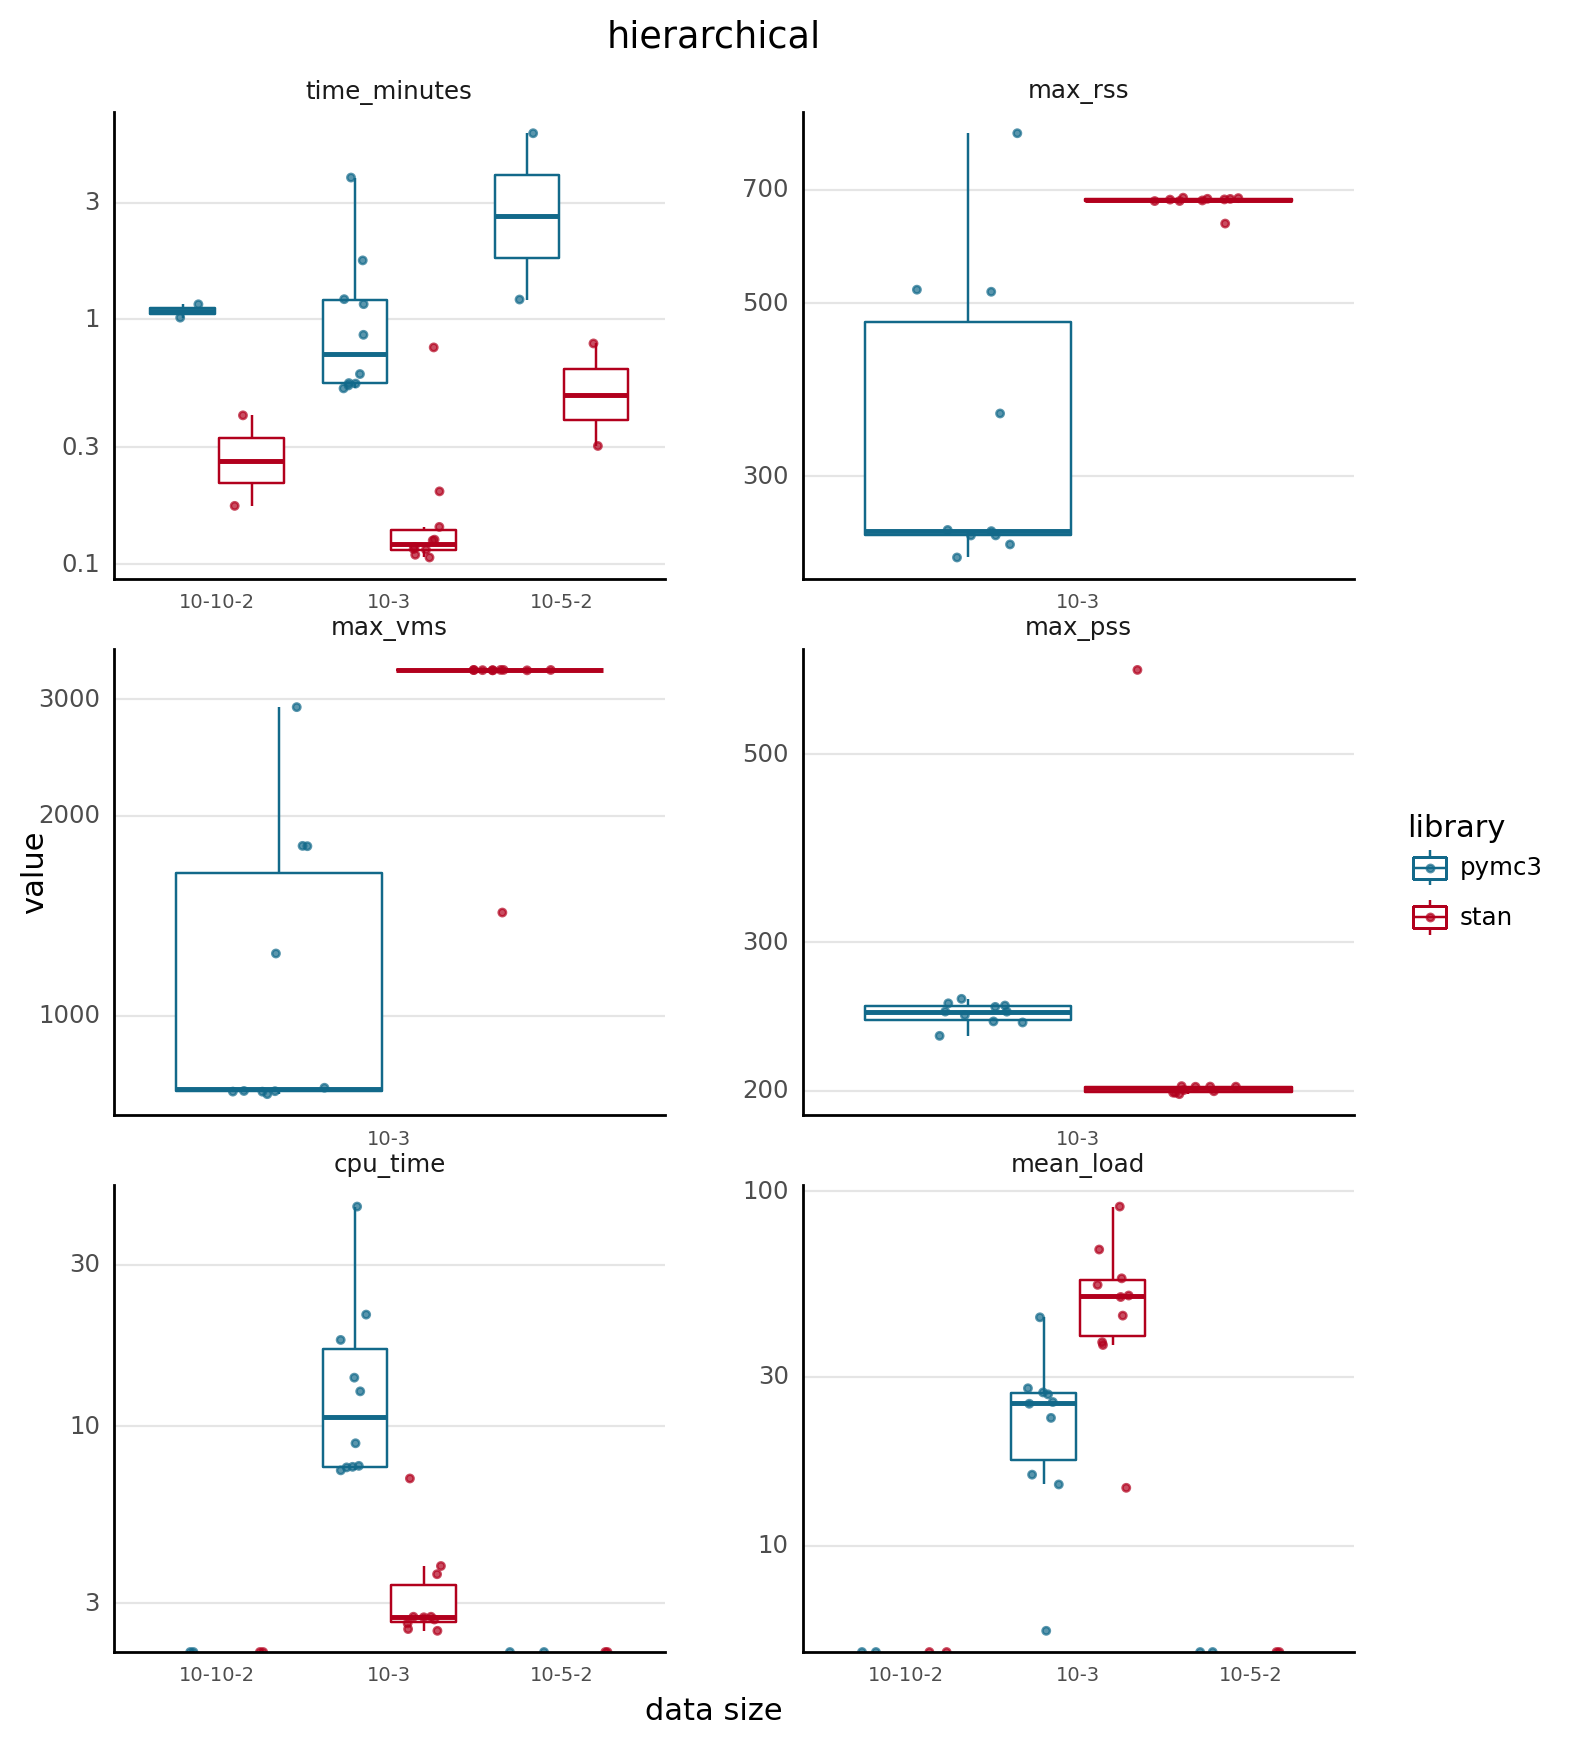

In [6]:
dpos = gg.position_dodge(width=0.8)
jpos = gg.position_jitterdodge(jitter_width=0.2, jitter_height=0, dodge_width=0.8)

for model in benchmarks_long.model.unique():
    print(
        gg.ggplot(
            benchmarks_long.query(f"model == '{model}'"),
            gg.aes(x="factor(data_size)", y="value", color="library"),
        )
        + gg.facet_wrap("variable", scales="free", ncol=2)
        + gg.geom_boxplot(outlier_alpha=0, position=dpos)
        + gg.geom_jitter(size=1, alpha=0.7, position=jpos)
        + gg.scale_y_log10()
        + gg.scale_color_manual(values=library_pal)
        + gg.theme(
            panel_grid_major_y=gg.element_line(),
            axis_text_x=gg.element_text(size=7),
            subplots_adjust={"wspace": 0.25, "hspace": 0.15},
            figure_size=(8, 10),
        )
        + gg.labs(x="data size", y="value", color="library", title=model)
    )


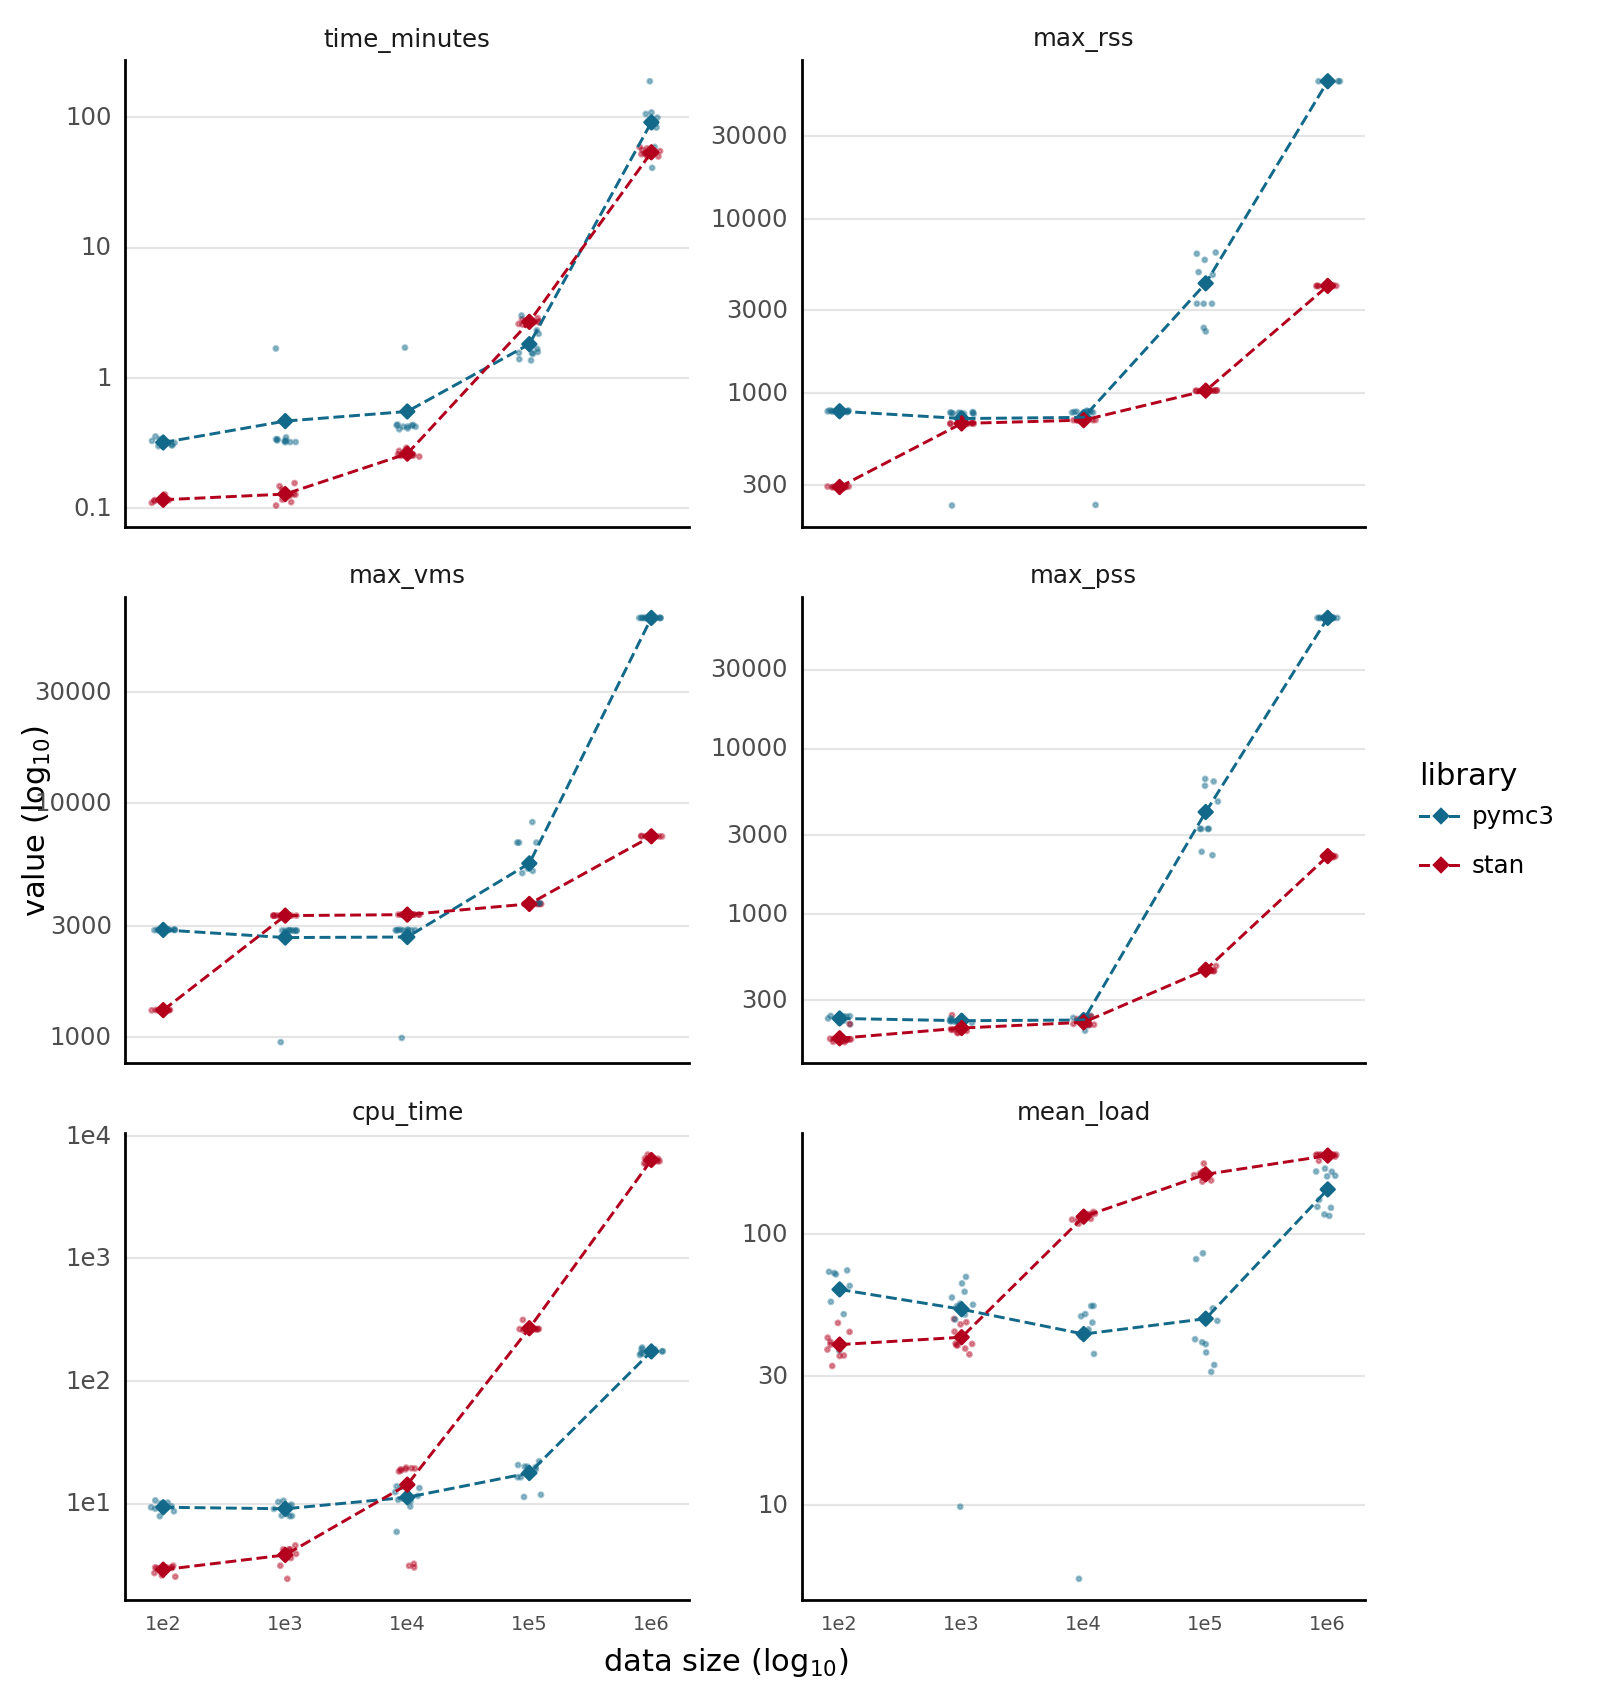

<ggplot: (312487141)>

In [7]:
simple_reg_benchmarks = (
    benchmarks_long.copy().query("model == 'simple'").astype({"data_size": int})
)
simple_reg_benchmarks_avg = (
    simple_reg_benchmarks.groupby(["variable", "library", "data_size"])
    .mean()
    .reset_index(drop=False)
)


(
    gg.ggplot(simple_reg_benchmarks, gg.aes(x="data_size", y="value", color="library"))
    + gg.facet_wrap("variable", scales="free_y", ncol=2)
    + gg.geom_jitter(size=0.4, alpha=0.4, width=0.1, height=0)
    + gg.geom_point(data=simple_reg_benchmarks_avg, shape="D", size=1.5)
    + gg.geom_line(data=simple_reg_benchmarks_avg, linetype="--", size=0.6)
    + gg.scale_x_log10()
    + gg.scale_y_log10()
    + gg.scale_color_manual(values=library_pal)
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        subplots_adjust={"wspace": 0.2, "hspace": 0.15},
        figure_size=(8, 10),
    )
    + gg.labs(x="data size ($\\log_{10}$)", y="value ($\\log_{10}$)", color="library")
)


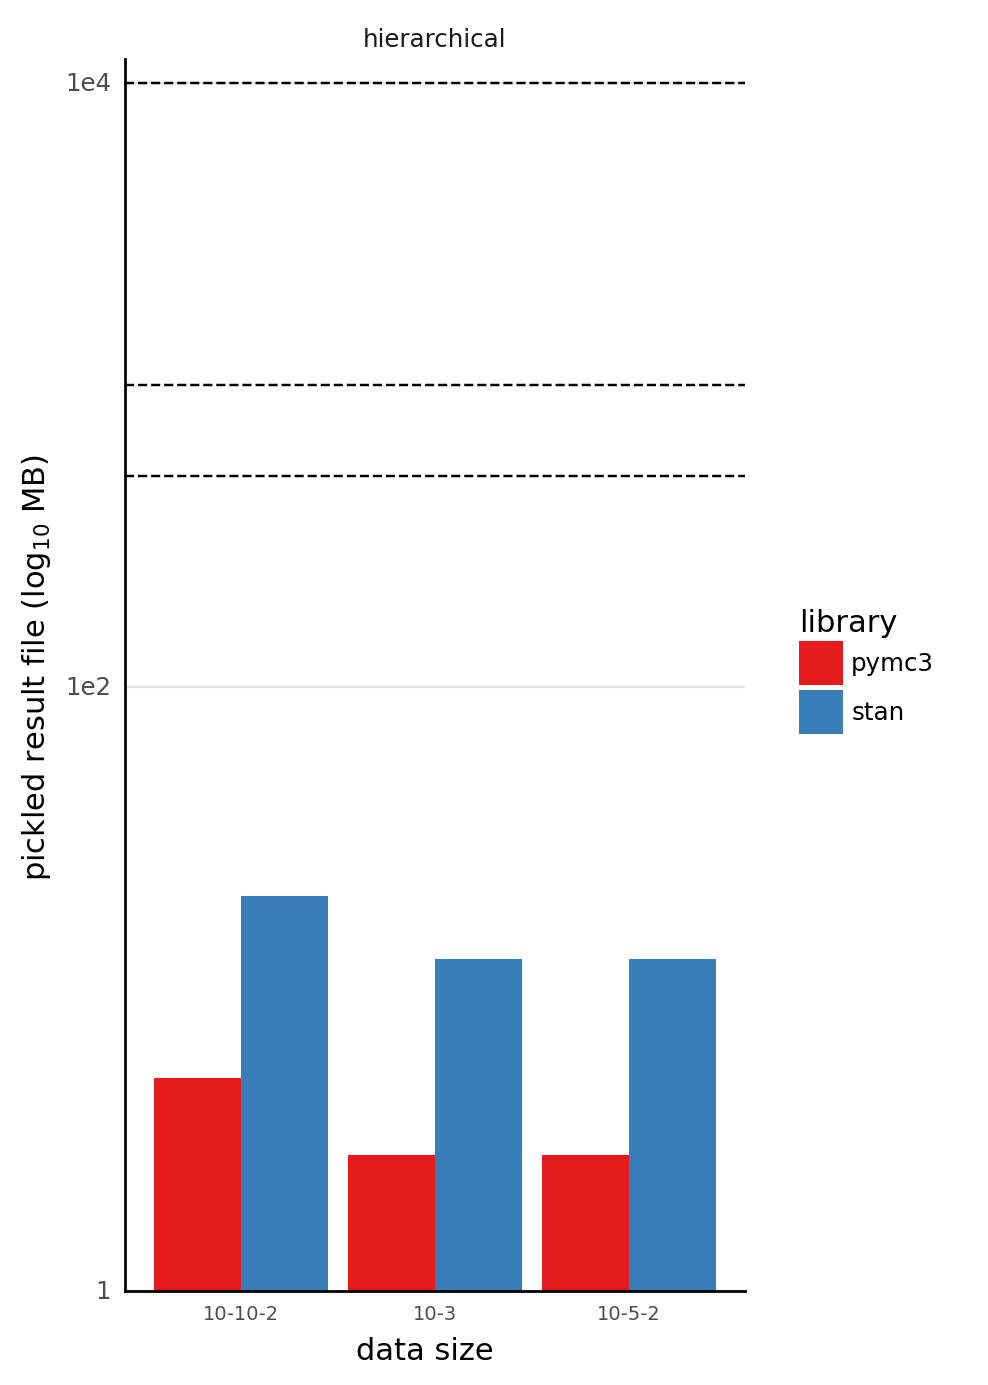

<ggplot: (311691499)>

In [8]:
result_file_sizes = pd.read_csv(model_size_csv).pipe(parse_model_names)

breaks: dict[str, float] = {"0.5 GB": 500, "1 GB": 1000, "10 GB": 10000}

(
    gg.ggplot(result_file_sizes, gg.aes(x="data_size", y="mb", fill="library"))
    + gg.facet_wrap("model", ncol=1, scales="free")
    + gg.geom_col(position="dodge")
    + gg.geom_hline(yintercept=breaks.values(), linetype="--", color="black")
    + gg.scale_y_log10(expand=(0, 0, 0.02, 0))
    + gg.scale_fill_brewer(type="qual", palette="Set1")
    + gg.theme(
        panel_grid_major_y=gg.element_line(),
        axis_text_x=gg.element_text(size=7),
        figure_size=(4, 8),
        subplots_adjust={"hspace": 0.5},
    )
    + gg.labs(x="data size", y="pickled result file ($\\log_{10}$ MB)", fill="library")
)


---

In [9]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2021-11-17

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 7.29.0

Compiler    : Clang 11.1.0 
OS          : Darwin
Release     : 20.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

Hostname: JHCookMac

Git branch: hierarchical-model

re      : 2.2.1
plotnine: 0.8.0
janitor : 0.21.2
pandas  : 1.3.4

